In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os

In [2]:
home = os.path.expanduser("~")
sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import DOG

In [3]:
speeds = np.round(np.arange(0.1,2.0,0.1),2)
speedsf = np.round(np.arange(2.,4.0,0.1),2)

speedsf = speedsf[::2]
speeds = speeds[::2][1:]

# slow speed range
speedslow = np.arange(0.12,0.2,0.01)
speedslow = np.round(speedslow[::2],2)

speedsff = np.round(np.arange(4.1,6.0,0.1),2)
speedsff = speedsff[::2]

speeds_full= np.concatenate((speedslow,speeds,speedsf,speedsff))
speedsmf = np.concatenate((speeds,speedsf))

In [4]:
speeds

array([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])

In [5]:
speeds_full

array([0.12, 0.14, 0.16, 0.18, 0.2 , 0.3 , 0.5 , 0.7 , 0.9 , 1.1 , 1.3 ,
       1.5 , 1.7 , 1.9 , 2.  , 2.2 , 2.4 , 2.6 , 2.8 , 3.  , 3.2 , 3.4 ,
       3.6 , 3.8 , 4.1 , 4.3 , 4.5 , 4.7 , 4.9 , 5.1 , 5.3 , 5.5 , 5.7 ,
       5.9 ])

In [6]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0

# load RAM simulations

In [7]:
data = {}
cell = 50


nets_list = ['fb_linear_nos/wBA/0.0',
             'fb_linear_nos/wBA/10.0',
            'ff_linear/wGA/0.0158']

            #  'ff_linear/wGA/wGA_0.0126' ]


for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    spss = []
    Fs = []
    RBs = []
    RAs = []
    RGs = []
    VGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []
    tp_bars = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []

    for s in speeds_full: 
        fp = f'../../output/{net}/smooth_{s}'
        with open(f'{fp}/out_smooth', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration'] 
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        mid_cell = int( paramsi['nb_GC_cells']/2 )
        pos_cell = paramsi['pos_rf_GC_mid'][mid_cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][mid_cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['inp'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['inp'][:])

        

        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['inp'])
        spss.append(out['spat'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        VGs.append(out['VG'])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)
        tp_bars.append(tp_bar)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray(peaks_drive)  
    data[net]['peaks']['bar'] =np.asarray(tp_bars)  
    

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['VG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['VG'] = VGs
    data[net]['F'] = Fs
    data[net]['spss'] = spss


    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times


In [8]:
net = nets_list[1]
net_pool = nets_list[0]
net_ff = nets_list[2]

# Figure Parameter

In [9]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 2
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]


In [10]:
cbar = 'grey'
c1 = 'blue'
c2 = 'red'

# parameter that control spatial and temporal convolution 

elaborate..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


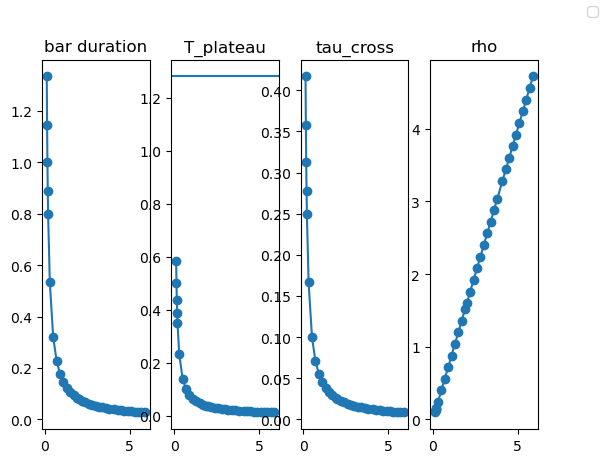

In [11]:
%matplotlib inline
def T_bar(b,v):
    return b/v

def kappa(b,sigma):
    return (2/5) * (b/sigma)


def T_plateau(b,sigma,v):
    return (2*b-5*sigma)/v

# calculate rho 
def taucross(v,sigma):
    return sigma/v

def rho(tau,taucross):
    return tau/taucross



tau = paramsi['tauOPL']
sigma = (paramsi['rf_BC']/6)
b = paramsi['bar_width']


Tbars = [T_bar(b,vi) for vi in speeds_full]
Tplats = [T_plateau(b,sigma,vi) for vi in speeds_full]
kap = kappa(b,sigma)
tcrosses = [taucross(vi,sigma) for vi in speeds_full]
rohs = [rho(tau,ti) for ti in tcrosses]


fig = plt.figure()

ax = fig.add_subplot(1,4,1)
ax.set_title('bar duration')
ax.scatter(speeds_full,Tbars)
ax.plot(speeds_full,Tbars)


ax = fig.add_subplot(1,4,2)
ax.set_title('T_plateau')
ax.scatter(speeds_full,Tplats)
ax.plot(speeds_full,Tplats)
ax.axhline(kap)


ax = fig.add_subplot(1,4,3)
ax.set_title('tau_cross')
ax.scatter(speeds_full,tcrosses)
ax.plot(speeds_full,tcrosses)


ax = fig.add_subplot(1,4,4)
ax.set_title('rho')
ax.scatter(speeds_full,rohs)
ax.plot(speeds_full,rohs)



fig.legend()



# plot spatial convolution for intermediate speeds

ValueError: x and y must be the same size

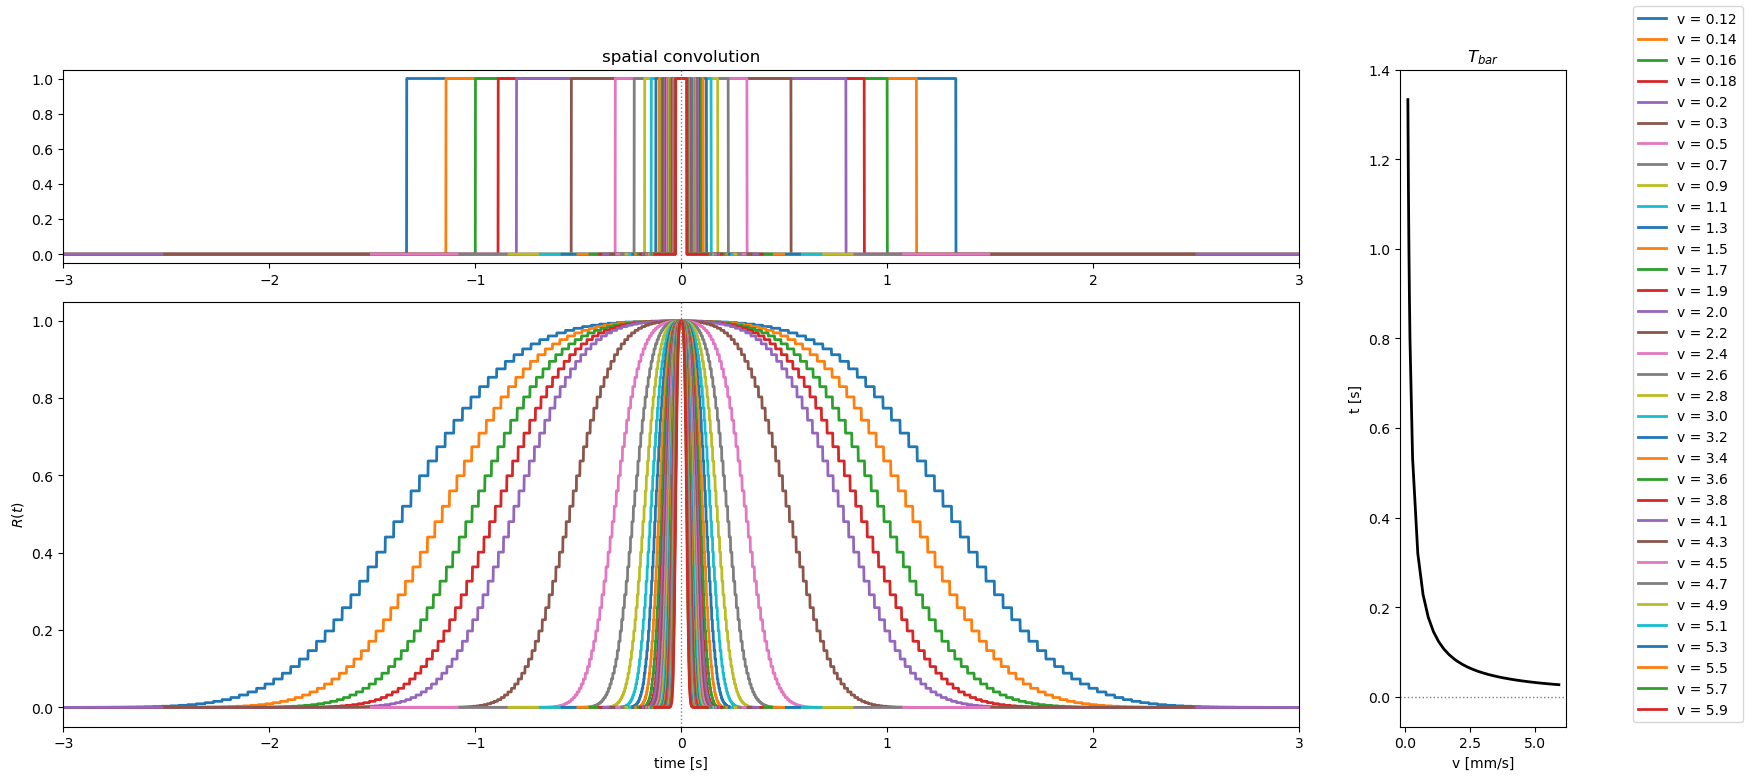

In [12]:
speeds= speeds_full
%matplotlib inline
#initialize figure
nrows = 3
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.2,
wspace=0.61)



c = []
gs = fig.add_gridspec(nrows,ncols)

# plot bar vs time for speeds
ax = fig.add_subplot(gs[0,0:5])
ax.set_title(r'spatial convolution')

x = 0

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]
    barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]

    line = ax.plot(ti  - pos_cell/si, barr, label = f'v = {np.round(si,2)}', linewidth = lw)
    c.append(line[0].get_color())

    # ax.plot([-b/si,b/si],[x*0.1+1.1,x*0.1+1.1], color = c[-1])
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


# plot spatial convolution vs time for speeds
ax = fig.add_subplot(gs[1:,:5], sharex = ax)
for x,si in enumerate(speeds[:]):
    ti = data['times'][x]
    RG = data[net]['spss'][x]
    ax.plot(ti  - pos_cell/si, RG, linewidth = lw)
    dur = (5*sigma+b)/si
    # ax.plot([-dur/2,dur/2],[x*0.1+1.1,x*0.1+1.1], color = c[x])

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('time [s]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-3,3)
fig.legend()


# ax = fig.add_subplot(gs[2,0:2], sharex = ax)
# for x,si in enumerate(speeds[:]):
#     ti = data['times'][x]
#     RG = data[net]['F'][x]
#     ax.plot(ti  - pos_cell/si, RG, linewidth = lw)
# ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
# ax.set_xlabel('time [s]')
# ax.set_ylabel('$R(t)$')
# ax.set_xlim(-1.,1)
# fig.legend()



#  plot T_bar
ax = fig.add_subplot(gs[:,5])
ax.set_title(r'$T_{bar}$')
ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('t [s]')

ax.plot(speeds,Tbars[:], color = 'k', linewidth = lw, label = f'T_{bar}')
# ax.plot(speeds,(5*sigma+2*b)/speeds, color = 'm', linewidth = lw, label = 'bar excites RF duration')
# ax.plot(speeds,(2*b-5*sigma)/speeds, color = 'g', linewidth = lw, label = 'plateau duration')
for x,si in enumerate(speeds[:]):
    point = ax.scatter(si,Tbars, zorder = 10, color = c[x])
    # ax.scatter(si,(5*sigma+2*b)/si, zorder = 10, color = c[x])
    # ax.scatter(si,(2*b-5*sigma)/si, zorder = 10, color = c[x])
               

# # plot plateau duration
# ax = fig.add_subplot(gs[:,2])
# ax.set_title(r'$T_{plateau}$')
# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# ax.plot(speeds,Tplats, color = 'm', linewidth = lw)

# for x,si in enumerate(speeds[:]):
#     ax.scatter(si,Tplats[x], zorder = 10, color = c[x])
# # ax.legend()
# #col = p.get_facecolors()[idx].tolist()
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel('t [s]')


# ax = fig.add_subplot(gs[:,4])

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# antis = data[net]['ants']['drive'] 


# ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# # ax.legend()


# #col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(r'$\Delta X$ [$mm$]')

# temporal convolution for intermediate speed range 

Text(0.0, 1.0, '$V(t_p)[mV]$')

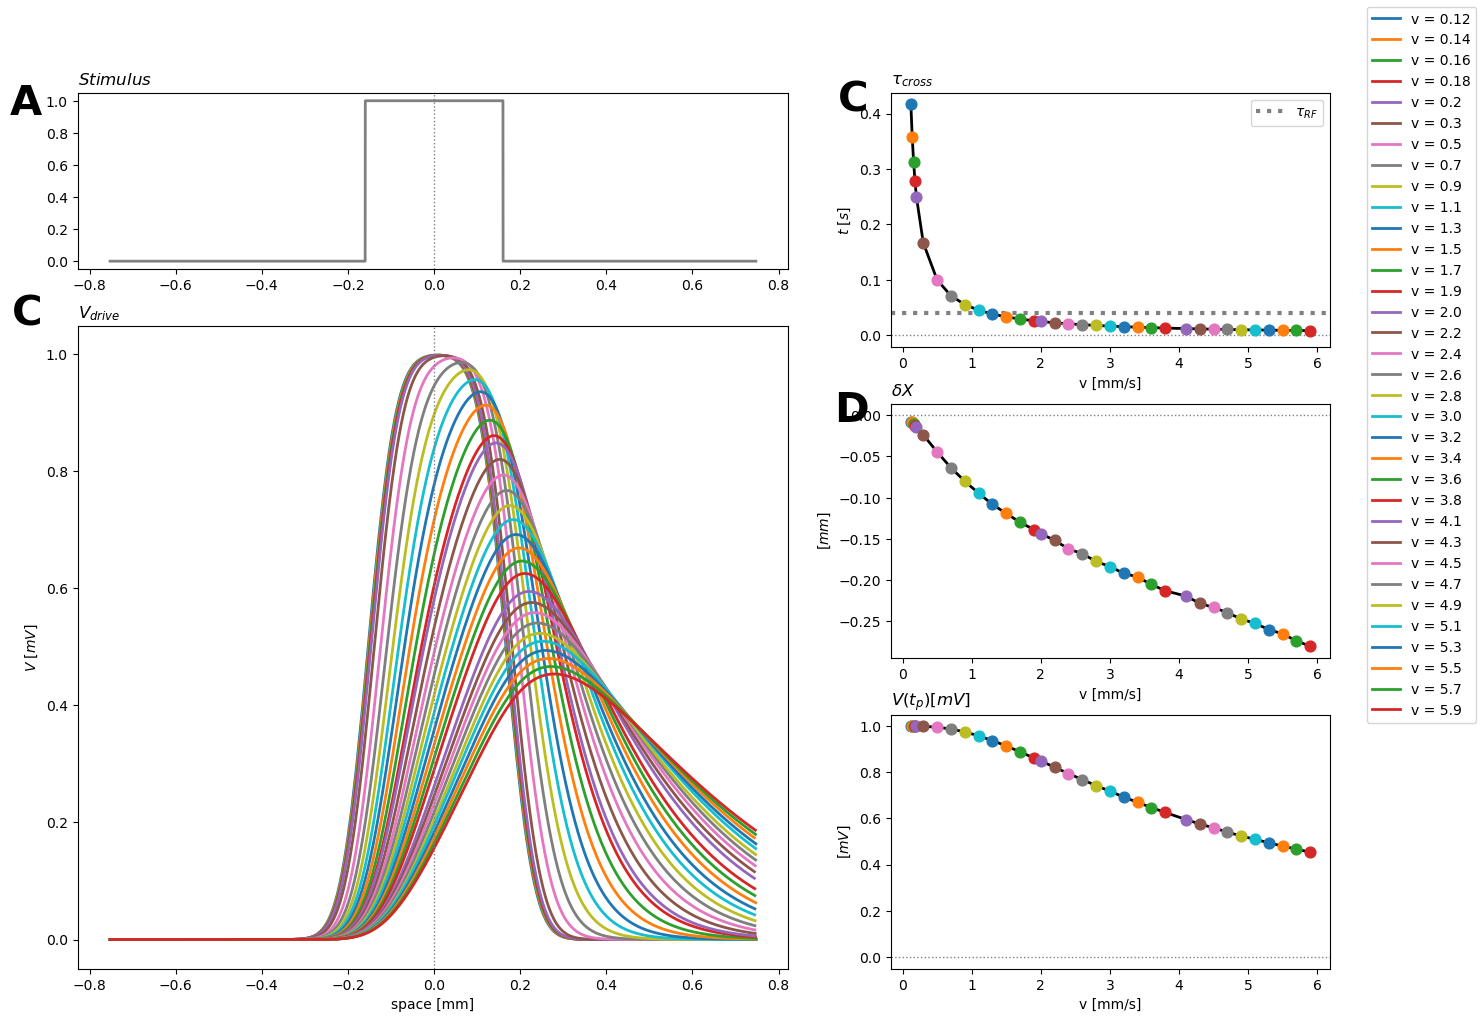

In [13]:
speeds =speeds_full
panellabel_position = [-0.05, .8]



%matplotlib inline
#initialize figure
nrows = 12
ncols = 5

fig = plt.figure(figsize=(15,12))
fig.patch.set_facecolor('white')


fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=2.7,
wspace=0.61)

gs = fig.add_gridspec(nrows,ncols)
ax = fig.add_subplot(gs[0:3,0:3])
ax.set_title(r'$Stimulus$', loc = 'left')

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


x = 0
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


# Vdrive vs space for may speeds
ax = fig.add_subplot(gs[3:,0:3], sharex = ax)


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.set_title(r'$V_{drive}$', loc = 'left')

for x,si in enumerate(speeds):
    ti = data['times'][x]*si
    RG = data[net]['F'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {np.round(si,2)}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$V$ [$mV$]')
# ax.set_xlim(-0.4,0.4)
fig.legend()



# t_cross
ax = fig.add_subplot(gs[:4,3:])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

ax.set_title(r'$\tau_{cross}$', loc = 'left')
ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.axhline(tau, linewidth = 3, color = cbar, linestyle = ':', label = r'$\tau_{RF}$')
antis = data[net]['ants']['drive'] * speeds
ax.plot(speeds,tcrosses, color = 'k', linewidth = lw)
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],tcrosses[x], s= ms, zorder = 10)

# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'$t$ [$s$]')
ax.legend()



# # rho 
# ax = fig.add_subplot(gs[4:8,4])
# ax.set_title(r'$\rho$')
# ax.axhline(1, linewidth = 1, color = cbar, linestyle = ':')
# ax.plot(speeds,rohs[len(speedslow):], color = 'k', linewidth = lw, label = 'lateral inhibition')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],rohs[len(speedslow)+x], s= ms, zorder = 10)
# # ax.legend()
# #col = p.get_facecolors()[idx].tolist()
# # ax.set_ylim(-.2,.15)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(r'')






# delta X for Vdrive against speed 
ax = fig.add_subplot(gs[4:8,3:])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "D", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.set_title(r'$\delta X$', loc = 'left')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['drive'] * speeds

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')


ax = fig.add_subplot(gs[8:,3:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['drive']

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# ax.legend()

#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'$[mV]$')
ax.set_title(r'$V(t_p)[mV]$', loc = 'left')



Text(0, 0.5, '[$mV$]')

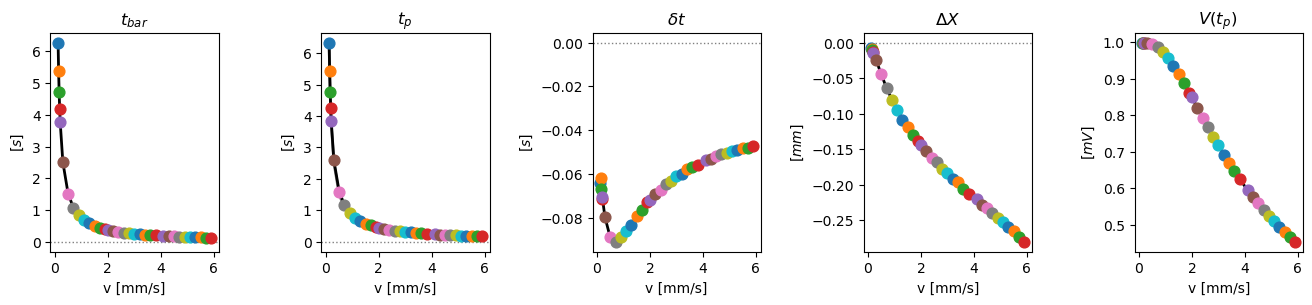

In [15]:
# plot tp  (equal to delta t = tp-tbar)

# plot V(tp)

# plot Xp = tp * v

%matplotlib inline
#initialize figure
nrows = 1
ncols = 5

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.2,
wspace=0.61)

gs = fig.add_gridspec(nrows,ncols)





# delta X for Vdrive against speed 
ax = fig.add_subplot(gs[0,0])
ax.set_title(r'$t_{bar}$ ')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
tbars = data[net]['peaks']['bar']

ax.plot(speeds,tbars, color = 'k', linewidth = lw, label = 'lateral inhibition')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],tbars[x], s= ms, zorder = 10)
# ax.legend()
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$s$]')



# delta X for Vdrive against speed 
ax = fig.add_subplot(gs[0,1])
ax.set_title(r'$t_p$ ')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
tpdrive = data[net]['peaks']['drive']

ax.plot(speeds,tpdrive, color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(speeds,tbars, color = 'k',alpha = 0.5,linewidth = lw, label = 'lateral inhibition')

for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],tpdrive[x], s= ms, zorder = 10)
# ax.legend()
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$s$]')



# delta X for Vdrive against speed 
ax = fig.add_subplot(gs[0,2])
ax.set_title(r'$\delta t$ ')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['drive']

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# ax.legend()
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$s$]')





# delta X for Vdrive against speed 
ax = fig.add_subplot(gs[0,3])
ax.set_title(r'$\Delta X$ ')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['drive'] * speeds

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')



# delta X for Vdrive against speed 
ax = fig.add_subplot(gs[0,4])
ax.set_title(r'$V(t_p)$ ')

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['drive'] 

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mV$]')


# ax = fig.add_subplot(gs[:,4:])

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# antis = data[net]['amps']['drive']

# ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
# # ax.legend()

# #col = p.get_facecolors()[idx].tolist()
# # ax.set_ylim(-.2,.15)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(' max R [$Hz$]')



In [19]:
np.savetxt("../../output/tpvdrive.txt",tpdrive)
np.savetxt("../../output/speeds.txt",speeds_full)

delta t starts to increase when the response maximum is not reached anymore ? 

# speedscaling in bipolars

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, '$R_{B}$')

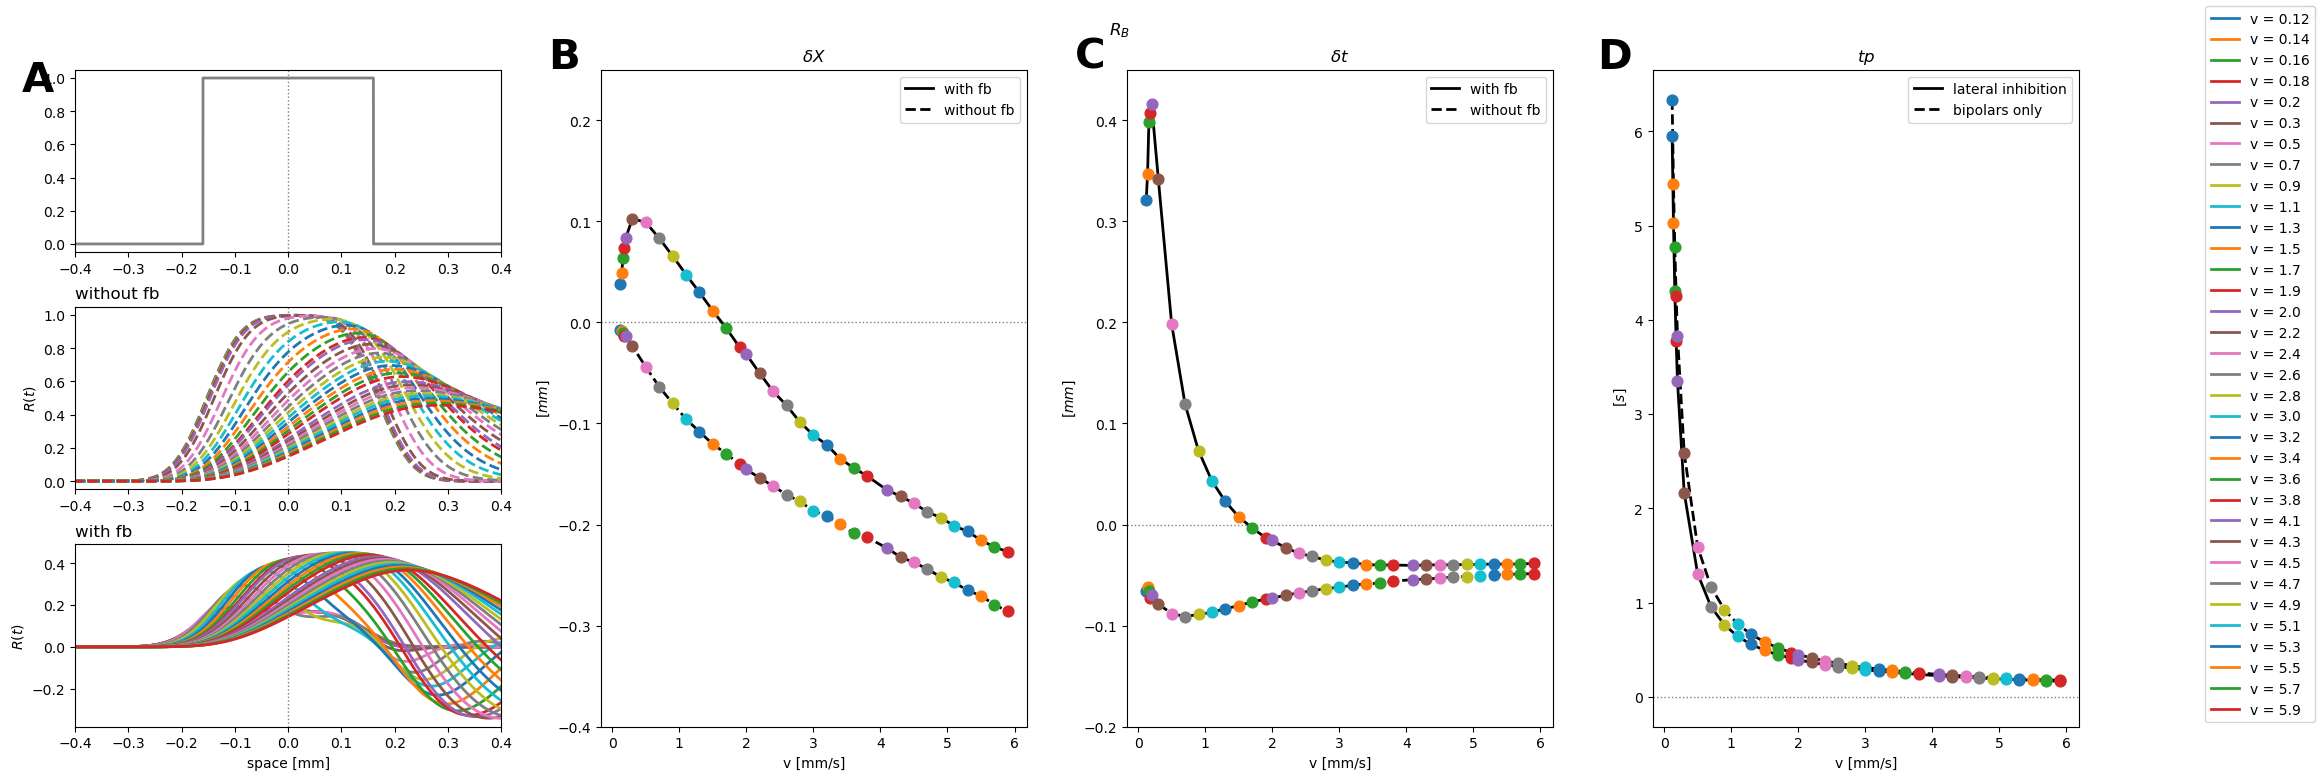

In [54]:
#initialize figure
nrows = 3
ncols = 8

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')

fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.3,
wspace=0.61)


gs = fig.add_gridspec(nrows,ncols)
ax = fig.add_subplot(gs[0,0:2])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

x = 0

ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ax = fig.add_subplot(gs[1,0:2], sharex = ax)
ax.set_title('without fb', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net_pool]['RB'][x]
    ax.plot(ti  - pos_cell, RG, linewidth = lw, linestyle = '--')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()


ax = fig.add_subplot(gs[2,0:2], sharex = ax)
ax.set_title('with fb', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RB'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()


ax = fig.add_subplot(gs[:,2:4])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RB_bar'] * speeds
antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'with fb')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'without fb')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.4,.25)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')
ax.set_title(r'$\delta X$')





ax = fig.add_subplot(gs[:,4:6])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RB_bar']
antis_pool = data[net_pool]['ants']['RB_bar'] 


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'with fb')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'without fb')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.2,.45)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')
ax.set_title(r'$\delta t$')



ax = fig.add_subplot(gs[:,6:])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "D", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['peaks']['RB']
antis_pool = data[net_pool]['peaks']['RB']

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(' [$s$]')
ax.set_title(r'$tp$')

# ax = fig.add_subplot(gs[:,4:])

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# antis = data[net]['amps']['RB']
# antis_pool = data[net_pool]['amps']['RB']

# ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'bipolars only')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
#     ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
# ax.legend()


# #col = p.get_facecolors()[idx].tolist()
# # ax.set_ylim(-.2,.15)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(' max R [$Hz$]')


fig.suptitle(r'$R_{B}$')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.0, 1.0, '$V(t_p)$')

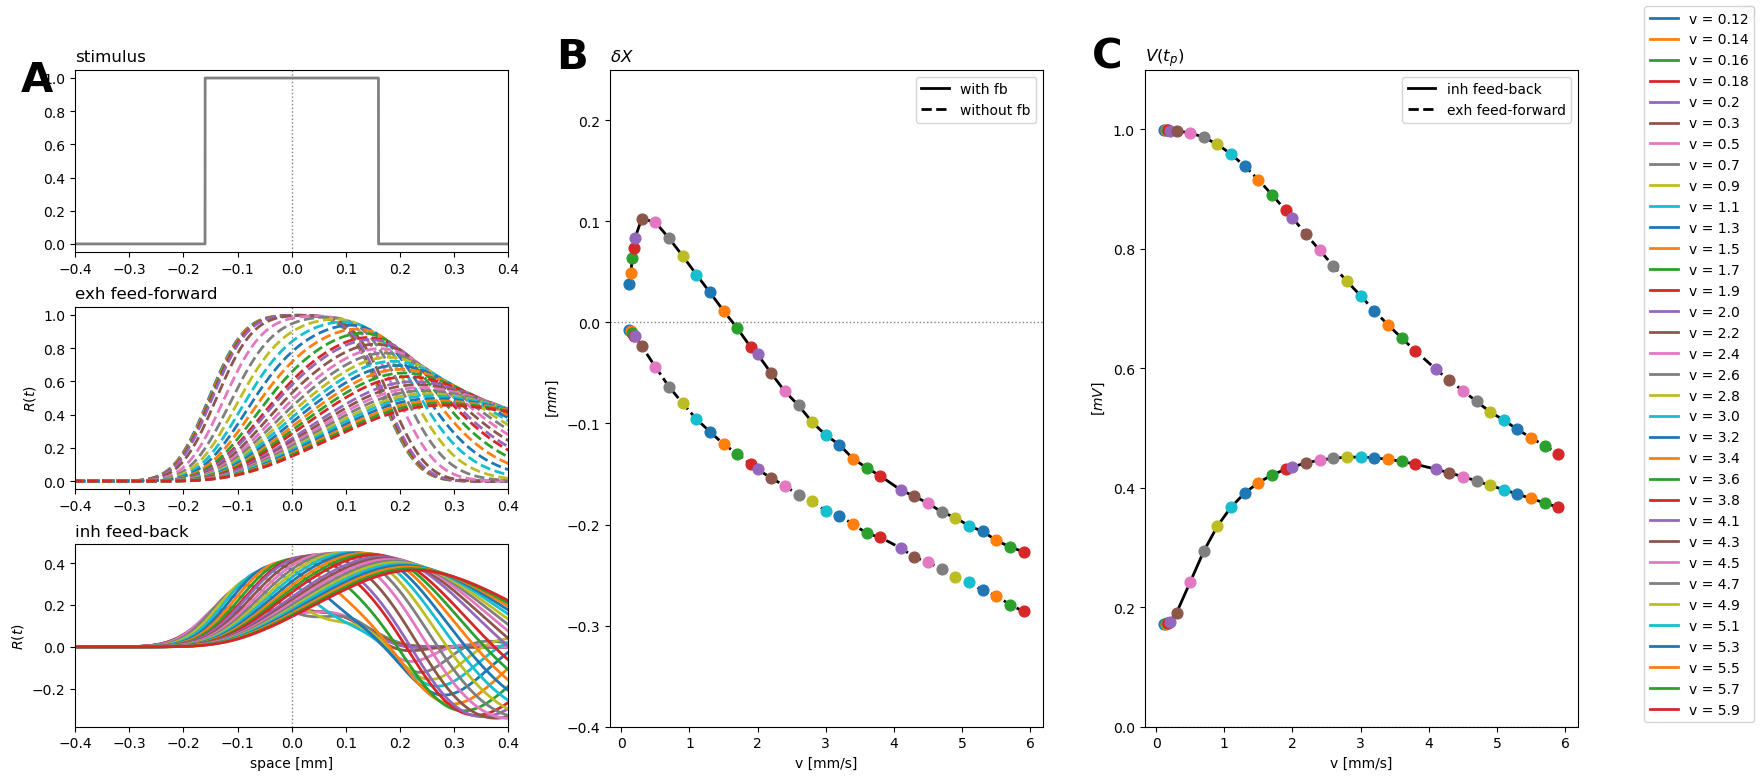

In [63]:
#initialize figure
nrows = 3
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')

fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.3,
wspace=0.61)


gs = fig.add_gridspec(nrows,ncols)
ax = fig.add_subplot(gs[0,0:2])
ax.set_title('stimulus', loc = 'left')
ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

x = 0

ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ax = fig.add_subplot(gs[1,0:2], sharex = ax)
ax.set_title('exh feed-forward', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net_pool]['RB'][x]
    ax.plot(ti  - pos_cell, RG, linewidth = lw, linestyle = '--')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()


ax = fig.add_subplot(gs[2,0:2], sharex = ax)
ax.set_title('inh feed-back', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RB'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()


ax = fig.add_subplot(gs[:,2:4])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RB_bar'] * speeds
antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'with fb')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'without fb')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.4,.25)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')
ax.set_title(r'$\delta X$', loc = 'left')





ax = fig.add_subplot(gs[:,4:6])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['RB']
antis_pool = data[net_pool]['amps']['RB'] 


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'inh feed-back')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'exh feed-forward')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(0.,1.1)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mV$]')
ax.set_title(r'$V(t_p)$', loc='left')



Text(0.5, 1.0, '$\\delta X$')

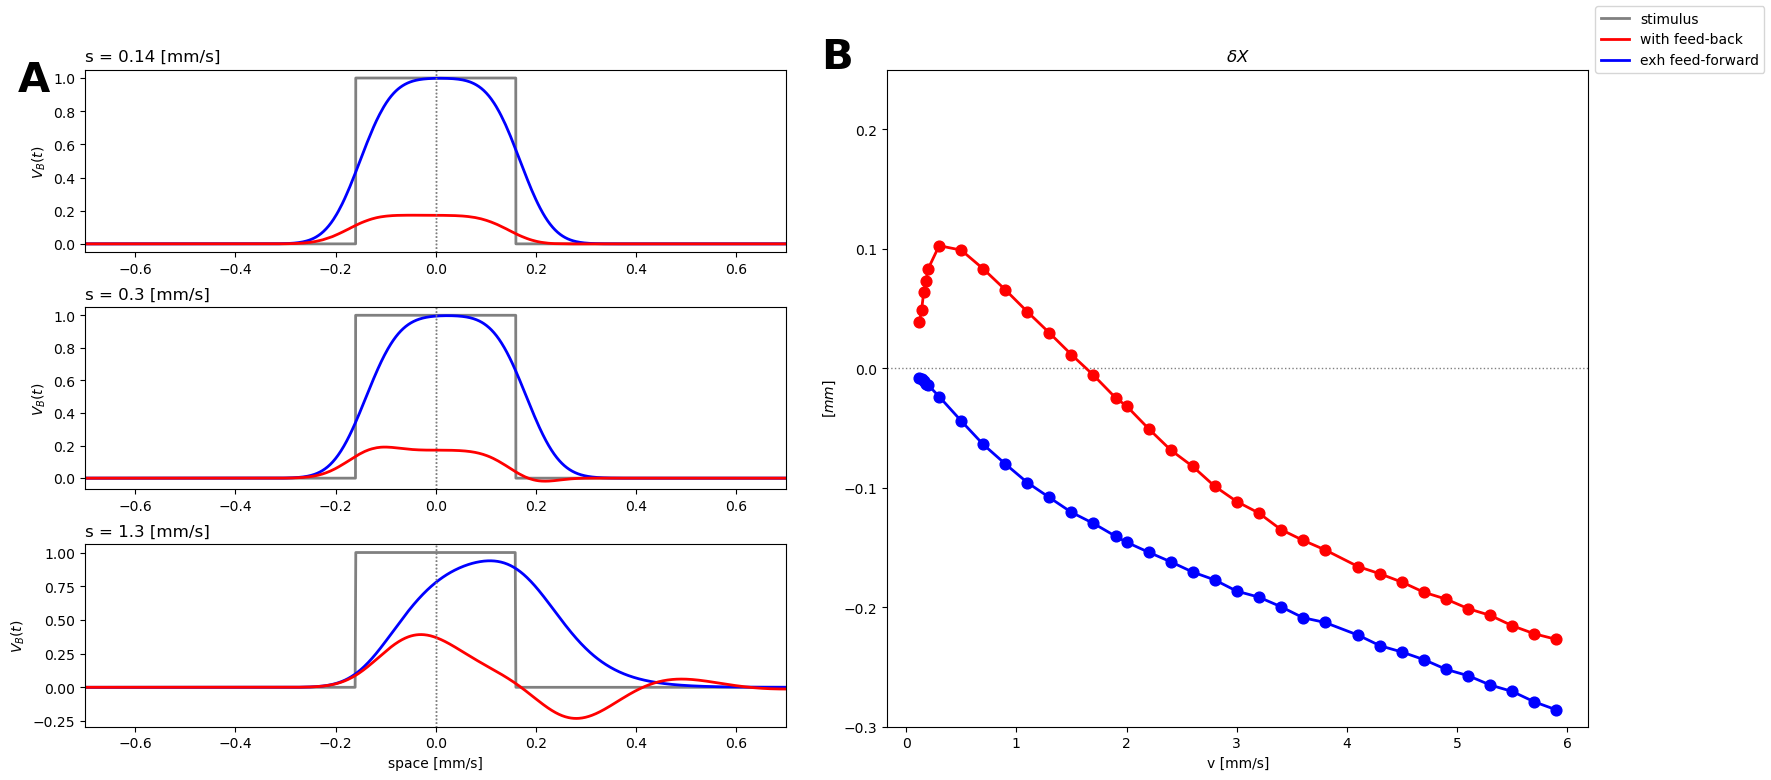

In [64]:
#initialize figure
nrows = 3
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')

fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.3,
wspace=0.61)


gs = fig.add_gridspec(nrows,ncols)


ax = fig.add_subplot(gs[0,:3])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

x = 1
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti  * speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar, label = 'stimulus')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RB'][x]
ax.plot(ti  - pos_cell, VB, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*speeds[x]
VB = data[net]['RB'][x]
ax.plot(ti  - pos_cell, VB, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[1,:3])
x = 5
ti = data['times'][x] 
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RB'][x]
ax.plot(ti  - pos_cell, VB, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*si
VB = data[net]['RB'][x]
ax.plot(ti  - pos_cell, VB, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[2,:3])
x = 10
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RB'][x]
ax.plot(ti  - pos_cell, VB, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*si
VB = data[net]['RB'][x]
ax.plot(ti  - pos_cell, VB, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_xlabel('space [mm/s]')
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')




# ax = fig.add_subplot(gs[0,1], sharex = ax)
# ax.set_title('without fb', loc = 'left')

# for x,si in enumerate(speeds[:]):
#     ti = data['times'][x]*si
#     RG = data[net_pool]['RB'][x]
#     ax.plot(ti  - pos_cell, RG, linewidth = lw, linestyle = '--')
# ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
# ax.set_ylabel('$R(t)$')
# ax.set_xlim(-0.4,0.4)
# fig.legend()


# ax = fig.add_subplot(gs[2,0:2], sharex = ax)
# ax.set_title('with fb', loc = 'left')

# for x,si in enumerate(speeds[:]):
#     ti = data['times'][x]*si
#     RG = data[net]['RB'][x]
#     ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
# ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
# ax.set_xlabel('space [mm]')
# ax.set_ylabel('$R(t)$')
# ax.set_xlim(-0.4,0.4)
# fig.legend()


ax = fig.add_subplot(gs[:,3:])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RB_bar'] * speeds
antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


ax.plot(speeds,antis, color = 'r', linewidth = lw, label = 'with feed-back')
ax.plot(speeds,antis_pool, color = 'b', linewidth = lw,linestyle = '-', label = 'exh feed-forward')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10, color = 'r')
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = 'b', s = ms, zorder = 10)
fig.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.3,.25)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')
ax.set_title(r'$\delta X$')



# ax = fig.add_subplot(gs[:,4:6])

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# antis = data[net]['ants']['RB_bar']
# antis_pool = data[net_pool]['ants']['RB_bar'] 


# ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'with fb')
# ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'without fb')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
#     ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
# ax.legend()


# #col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.25)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(r'[$mm$]')
# ax.set_title(r'$\delta t$')



# ax = fig.add_subplot(gs[:,6:])

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# antis = data[net]['peaks']['RB']
# antis_pool = data[net_pool]['peaks']['RB']

# ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'bipolars only')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
#     ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
# ax.legend()


# #col = p.get_facecolors()[idx].tolist()
# # ax.set_ylim(-.2,.15)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(' [$s$]')
# ax.set_title(r'$tp$')

# ax = fig.add_subplot(gs[:,4:])

# ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
# antis = data[net]['amps']['RB']
# antis_pool = data[net_pool]['amps']['RB']

# ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'bipolars only')
# for x,si in enumerate(speeds[:]):
#     p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
#     ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
# ax.legend()


# #col = p.get_facecolors()[idx].tolist()
# # ax.set_ylim(-.2,.15)
# #ax.set_xscale('log')
# ax.set_xlabel('v [mm/s]')
# ax.set_ylabel(' max R [$Hz$]')


# fig.suptitle(r'$R_{B}$')


# speedscaling in ganglion

Text(0.0, 1.0, '$R(t_p)$')

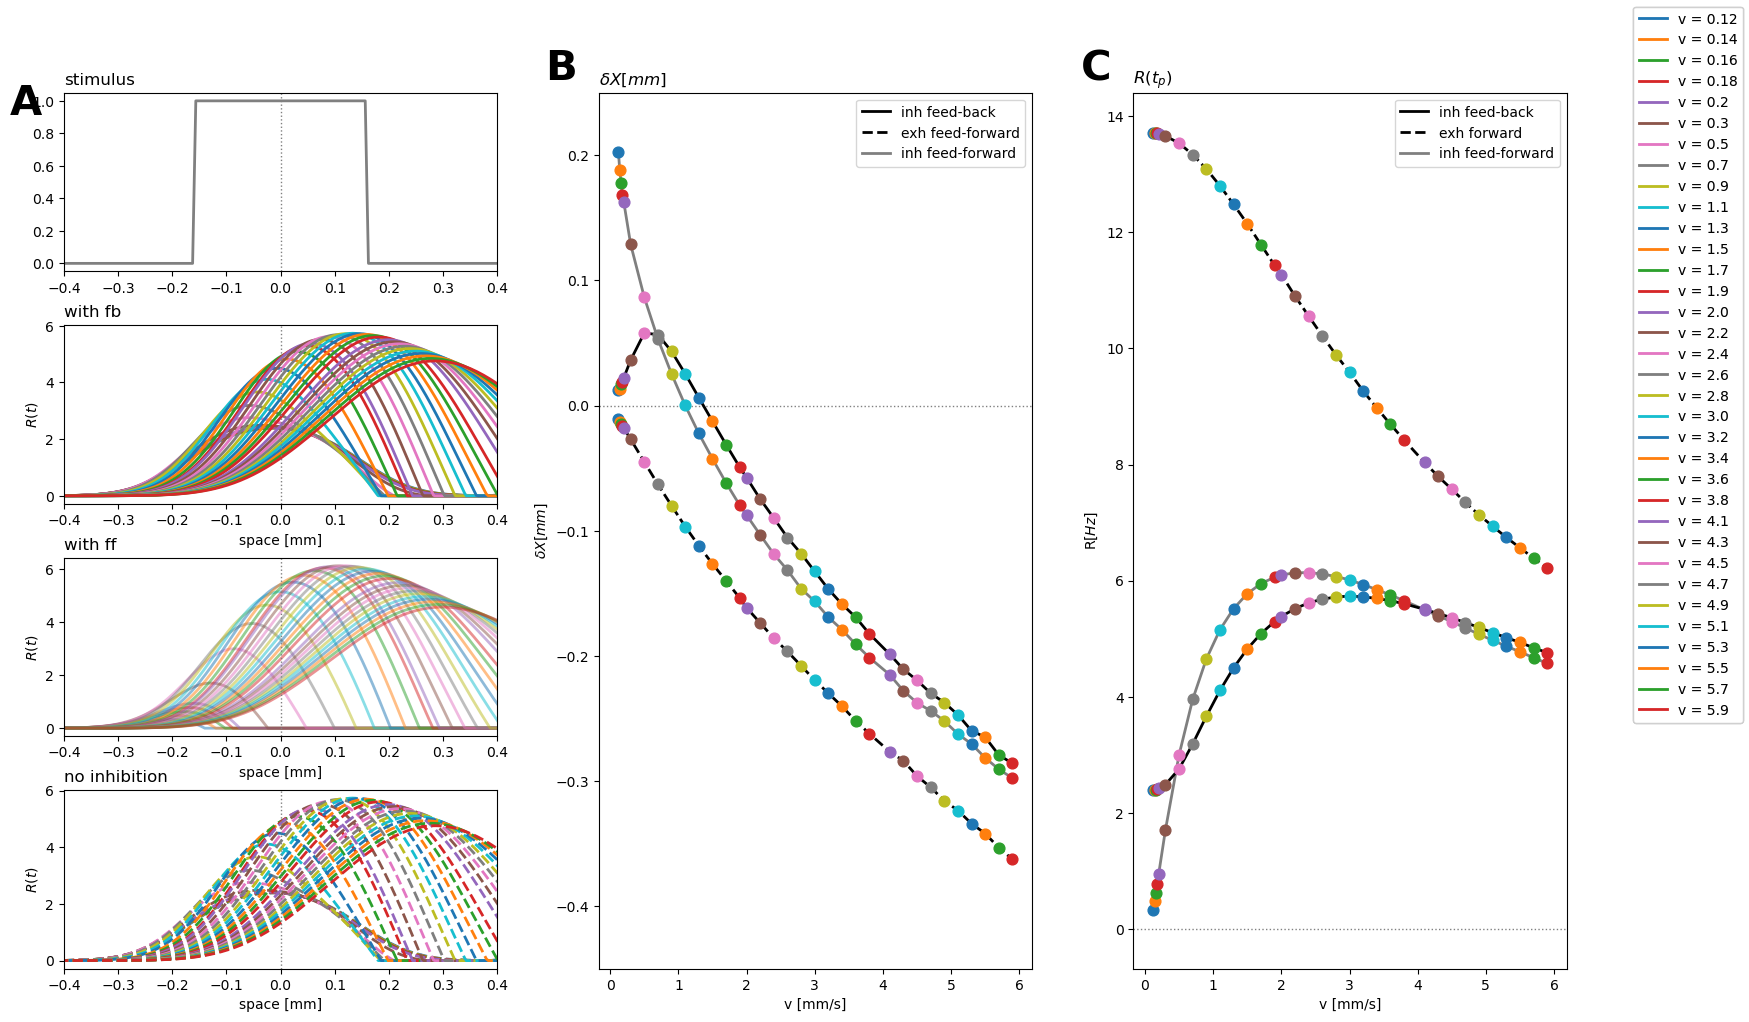

In [67]:
#initialize figure
nrows = 4
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.3,
wspace=0.61)


gs = fig.add_gridspec(nrows,ncols)
ax = fig.add_subplot(gs[0,0:2])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')



ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_title('stimulus', loc = 'left')
ax = fig.add_subplot(gs[1,0:2], sharex = ax)
ax.set_title('with fb', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RG'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()


ax = fig.add_subplot(gs[2,0:2], sharex = ax)
ax.set_title('with ff', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net_ff]['RG'][x]
    ax.plot(ti  - pos_cell, RG, linewidth = lw, alpha = .5)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()



ax = fig.add_subplot(gs[3,0:2], sharex = ax)
ax.set_title('no inhibition', loc = 'left')

for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RG'][x]
    ax.plot(ti  - pos_cell, RG, linewidth = lw, linestyle = '--')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()



ax = fig.add_subplot(gs[:,2:4])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RG_bar'] * speeds
antis_pool = data[net_pool]['ants']['RG_bar'] * speeds
antis_ff = data[net_ff]['ants']['RG_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'inh feed-back')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'exh feed-forward')
ax.plot(speeds,antis_ff, color = 'k', linewidth = lw,alpha = .5, label = 'inh feed-forward')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
    ax.scatter(speeds[x],antis_ff[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.45,.25)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'$\delta X [mm]$')
ax.set_title(r'$\delta X [mm]$', loc = 'left')
ax = fig.add_subplot(gs[:,4:])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['RG']
antis_pool = data[net_pool]['amps']['RG']
antis_ff = data[net_ff]['amps']['RG']


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'inh feed-back')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = '--', label = 'exh forward')
ax.plot(speeds,antis_ff, color = 'k', linewidth = lw,alpha = .5, label = 'inh feed-forward')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
    ax.scatter(speeds[x],antis_ff[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('R[$Hz$]')
ax.set_title(r'$R(t_p)$', loc = 'left')



/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_65025/886541762.py:227: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend((one,two,thr), loc = 'lower right', labels = ('stimulus', 'inh feed-forward', 'exh feed-forward'), bbox_to_anchor = (1.,0.4), fontsize = fontsize_legend)


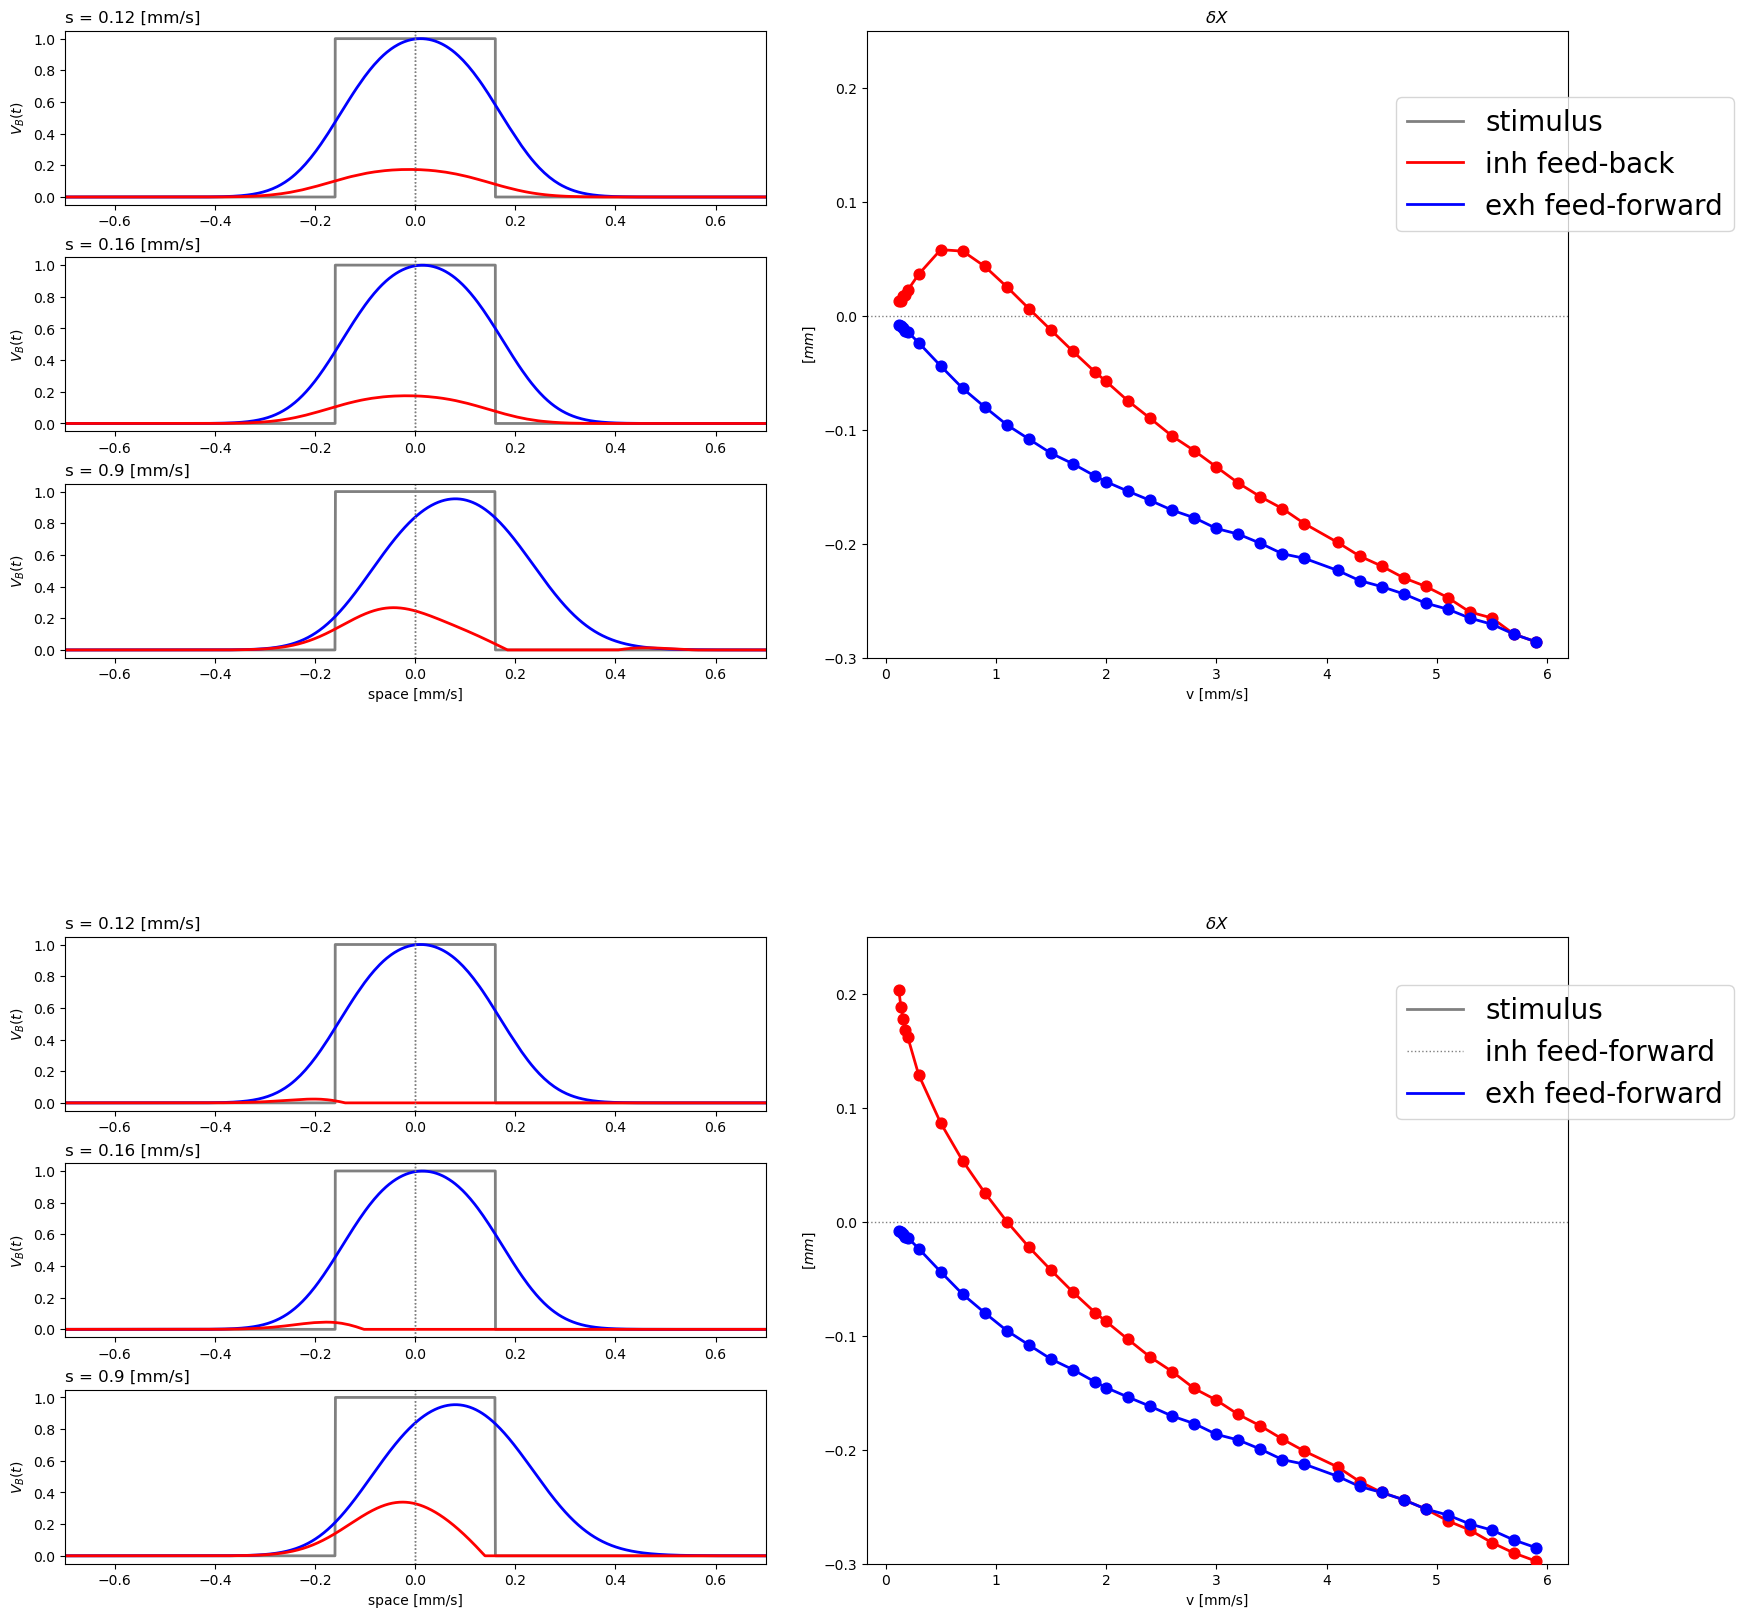

In [52]:
#initialize figure
nrows = 7
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')

fig.subplots_adjust(top=0.925,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.3,
wspace=0.61)


gs = fig.add_gridspec(nrows,ncols)


ax = fig.add_subplot(gs[0,:3])
x = 0
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti  * speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar, label = 'stimulus')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RG'][x]
VBref = VB.max()
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*speeds[x]
VB = data[net]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[1,:3])
x = 2
ti = data['times'][x] 
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*si
VB = data[net]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[2,:3])
x = 8
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*si
VB = data[net]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_xlabel('space [mm/s]')
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')




ax = fig.add_subplot(gs[:3,3:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RG_bar'] * speeds
antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


ax.plot(speeds,antis, color = 'r', linewidth = lw, label = 'inh feed-back')
ax.plot(speeds,antis_pool, color = 'b', linewidth = lw,linestyle = '-', label = 'exh feed-forward')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10, color = 'r')
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = 'b', s = ms, zorder = 10)
fig.legend(loc = 'upper right', bbox_to_anchor = (1.,.9), fontsize =fontsize_legend)


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.3,.25)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')
ax.set_title(r'$\delta X$')



###### FEED FORWARD

ax = fig.add_subplot(gs[4,:3])
x = 0
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti  * speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar, label = 'stimulus')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RG'][x]
VBref = VB.max()
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*speeds[x]
VB = data[net_ff]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[5,:3])
x = 2
ti = data['times'][x] 
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*si
VB = data[net_ff]['RG'][x]
thr = ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[6,:3])
x = 8
ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
one = ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ti = data['times'][x]*speeds[x]
VB = data[net_pool]['RG'][x]
two = ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'b')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
# fig.legend()


# ti = data['times'][x]*si
VB = data[net_ff]['RG'][x]
ax.plot(ti  - pos_cell, VB/VBref, linewidth = lw, linestyle = '-', color = 'r')
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('$V_{B}(t)$')
ax.set_xlim(-0.7,0.7)
# fig.legend()
ax.set_xlabel('space [mm/s]')
ax.set_title(f's = {speeds[x]} [mm/s]', loc = 'left')


ax = fig.add_subplot(gs[4:,3:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net_ff]['ants']['RG_bar'] * speeds
antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


thr = ax.plot(speeds,antis, color = 'r', linewidth = lw, label = 'inh feed-forward')
ax.plot(speeds,antis_pool, color = 'b', linewidth = lw,linestyle = '-', label = 'exh feed-forward')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10, color = 'r')
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = 'b', s = ms, zorder = 10)
# fig.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.3,.25)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel(r'[$mm$]')
ax.set_title(r'$\delta X$')

fig.legend((one,two,thr), loc = 'lower right', labels = ('stimulus', 'inh feed-forward', 'exh feed-forward'), bbox_to_anchor = (1.,0.4), fontsize = fontsize_legend)
